# Домашнее задание 5. Линейные модели

### Libraries

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.preprocessing import normalize

In [3]:
from sklearn.metrics import auc, roc_curve

In [313]:
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif

In [5]:
import sklearn.linear_model as sl

In [6]:
import sklearn.ensemble as se

In [7]:
from sklearn.cross_validation import cross_val_score

### Data

In [8]:
def load_data(path):
    data = np.load(path)
    users = data["users"]
    return data["data"].reshape(1,)[0], users

In [9]:
def load_users(training, example):
    df_users_train = pd.read_csv(training, sep=",", header=0)
    df_users_ex = pd.read_csv(example, sep=",", header=0)
    df_users_ex['cat'] = None
    return df_users_train, df_users_ex, pd.concat([df_users_train, df_users_ex])

### Features

In [10]:
def count_freq(x):
    freq = np.array((x!=0).sum(axis = 0)).reshape(-1,)
    return freq

In [11]:
def cut_features(X, features_counts, features_border):
    return X.tocsc()[:, features_counts > features_border].toarray()

In [12]:
def select_features(X, selector):
    return selector.transform(X)

### ROC-кривая

In [13]:
def count_roc(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [14]:
def classify(X, Y, clf, test_size = 0.3):
    x_train, x_test, y_train, y_test = cv.train_test_split(X, Y, test_size=test_size)
    clf.fit(x_train, y_train)
    y_prob = clf.predict_proba(x_test)[:,1]
    return count_roc(y_test, y_prob) 

def plot_roc_curve(fpr, tpr, roc_auc): 
    """Plot ROC curve"""
    plt.figure(figsize=(5,5))
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

### Classifiers

In [309]:
def select_parameter(C, X, Y, Classifier, n_folds = 10):
    kf = cv.KFold(n=len(Y), n_folds=n_folds, shuffle=True)
    results = []
    for i, c in enumerate(C):
        print 'No.: %d of %d =============' % (i+1, len(C))
        #clf = Classifier(C=c)
        clf = Classifier(C=c, penalty='l2', solver='sag', tol=1e-4, n_jobs=-1)
        scores = []
        for j, (train_index, test_index) in enumerate(kf):
            clf.fit(X[train_index],Y[train_index])
            y_prob = clf.predict_proba(X[test_index])[:,1]
            fpr, tpr, roc_auc = count_roc(Y[test_index], y_prob)
            scores.append(roc_auc)
        results.append(np.mean(scores))
        print "%.3f:\t" % c, results[-1], scores
    return results.index(max(results))

In [310]:
def count_quality(C, X, Y, Classifier, n_folds=10, test_size = 0.3):
    index = select_parameter(C, X, Y, Classifier, n_folds)
    #clf = Classifier(C=C[index])
    clf = Classifier(C=C[index], penalty='l2', solver='sag', tol=1e-4, n_jobs=-1)
    fpr, tpr, roc_auc = classify(X, Y, clf, test_size)
    plot_roc_curve(fpr, tpr, roc_auc)
    return C[index]

## Main

In [17]:
DATASET_PATH = "out_4.dat.npz"
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"

In [18]:
X_dataset, users = load_data(DATASET_PATH)
df_users_train, df_users_ex, df_users = load_users(TRAINING_SET_URL, EXAMPLE_SET_URL)

## X, Y

In [19]:
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]
train_ids = users[np.where(ix)]

In [20]:
train_labels = df_users_train['cat'].values
Y = np.array(map(lambda y: train_labels[np.where(train_users == y)[0][0]], train_ids))
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (4935x264014) feature matrix, 4935 target vector


## Processing features

In [714]:
percent_features = 15
features_border = 5
features_counts = count_freq(X)

In [715]:
X1 = cut_features(X, features_counts, features_border)

In [716]:
X1 = normalize(X1)

In [717]:
selector = SelectPercentile(f_classif, percent_features) #chi2
X2 = selector.fit_transform(X1, Y)

In [718]:
print X2.shape

(4935, 3797)


In [719]:
C = [0.1, 0.2, 0.5, 1]
Classifier = sl.LogisticRegression

No.: 1 of 4 =============
0.100:	0.71387421459 [0.72350589225589224, 0.71997119526509035, 0.70943515221590081, 0.70258461862399324]
No.: 2 of 4 =============
0.200:	0.719050261768 [0.72974010942760947, 0.72436549424036711, 0.71414418794097945, 0.7079512554613886]
No.: 3 of 4 =============
0.500:	0.727332363778 [0.73954650673400679, 0.73121975962764107, 0.7211604409465372, 0.71740274780228463]
No.: 4 of 4 =============
1.000:	0.735252728668 [0.74835858585858595, 0.73848401941691444, 0.7277562443337845, 0.72641206506290468]


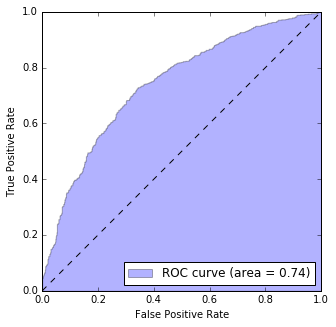

In [720]:
best_C = count_quality(C, X2, Y, Classifier, 4, 0.3)

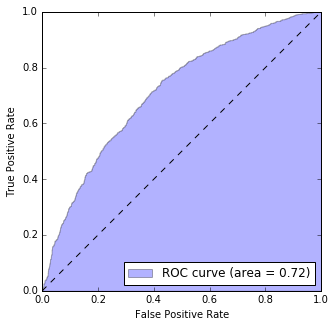

In [721]:
clf = Classifier(C=best_C)
fpr, tpr, roc_auc = classify(X2, Y, clf, 0.6)
plot_roc_curve(fpr, tpr, roc_auc)

In [672]:
print best_C

1


## Selecting best classifier

## Final results

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [722]:
predict_users = df_users_ex["uid"].values
ix = np.in1d(users, predict_users).reshape(users.shape)
X_p = normalize(cut_features(X_dataset[np.where(ix)], features_counts, features_border))
X_predict = normalize(selector.transform(X_p))
#X_predict = normalize(X_dataset[np.where(ix)].tocsc()[:, features_counts > 100].toarray())
predict_users_ids = users[np.where(ix)]
unknown_users_ids = filter(lambda x: x not in users, df_users_ex['uid'].values)

In [756]:
#model = Classifier(C=1000)#(C=best_C, penalty='l2', solver='sag', tol=1e-7)
model = Classifier(C=0.25, penalty='l2', solver='newton-cg', tol=1e-7, n_jobs=-1)
model.fit(normalize(X2), Y)
y_predicted_prob = model.predict_proba(X_predict)[:,1]

In [757]:
y_predicted_prob[4]

0.673152831853983

In [758]:
y_predicted_prob[y_predicted_prob > 1] = 1
y_predicted_prob[y_predicted_prob < 0] = 0

In [759]:
y_unknown_prob = np.array([0.5]*len(unknown_users_ids))

In [760]:
with open('./predicted.txt', 'w') as f:
    f.write('uid,cat\n')
    for i in range(len(y_predicted_prob)):
        f.write('%d,%f\n' % (predict_users_ids[i], y_predicted_prob[i]))
    for i in range(len(y_unknown_prob)):
        f.write('%d,%f\n' % (unknown_users_ids[i], y_unknown_prob[i]))

In [761]:
max_predicted = pd.read_csv("max_predicted.txt", sep=",", header=0)
ind = np.argsort(max_predicted.cat.values)
max_predicted = max_predicted.cat.values[ind]

In [762]:
last_predicted = pd.read_csv("predicted.txt", sep=",", header=0)
last_predicted = last_predicted.cat.values[ind]
nb = 0
for i in range(len(max_predicted)):
    b = (last_predicted[i] < 0.5) & (max_predicted[i] < 0.5) |\
    (last_predicted[i] >= 0.5) & (max_predicted[i] >= 0.5)
    nb+=b
float(nb)/len(max_predicted)

0.9199157007376185

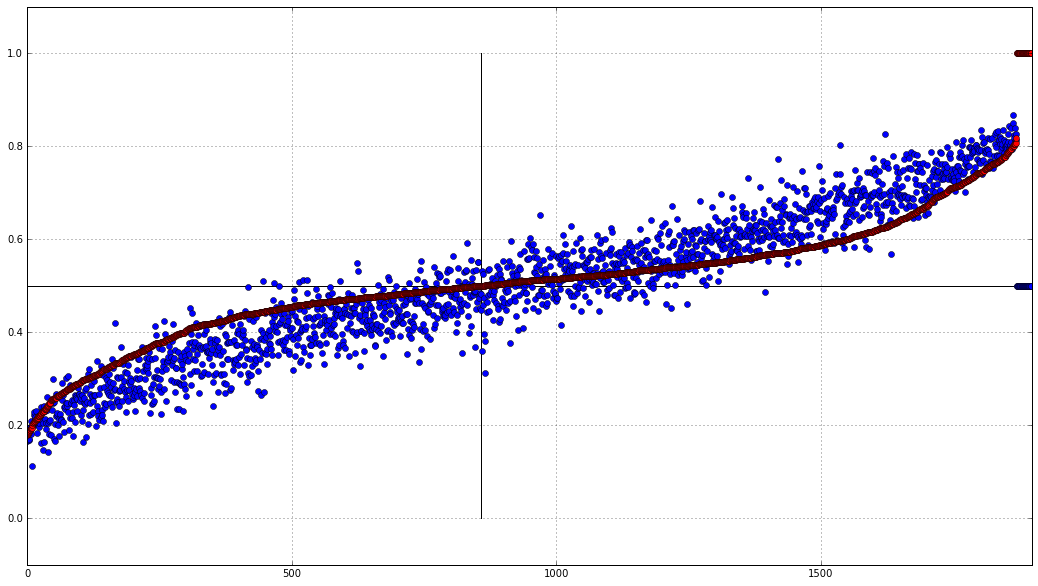

In [763]:
pl.figure(figsize=(18,10))
pl.xlim(0, len(last_predicted))
pl.ylim(-0.1, 1.1)
pl.grid(len(max_predicted))
pl.plot([0,len(last_predicted)], [0.5, 0.5], 'black')
pl.plot([np.where(max_predicted >= 0.5)[0][0], np.where(max_predicted >= 0.5)[0][0]], [0, 1], 'black')
pl.plot(range(len(last_predicted)), last_predicted, 'bo')
pl.plot(range(len(max_predicted)), max_predicted, 'ro')

In [739]:
from sklearn.manifold import TSNE

In [713]:
ts = TSNE(n_components=2, verbose=True)
XT = ts.fit_transform(X2, Y)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4935
[t-SNE] Computed conditional probabilities for sample 2000 / 4935
[t-SNE] Computed conditional probabilities for sample 3000 / 4935
[t-SNE] Computed conditional probabilities for sample 4000 / 4935
[t-SNE] Computed conditional probabilities for sample 4935 / 4935
[t-SNE] Mean sigma: 0.061824
[t-SNE] Error after 100 iterations with early exaggeration: 1.183328
[t-SNE] Error after 400 iterations: 1.085364


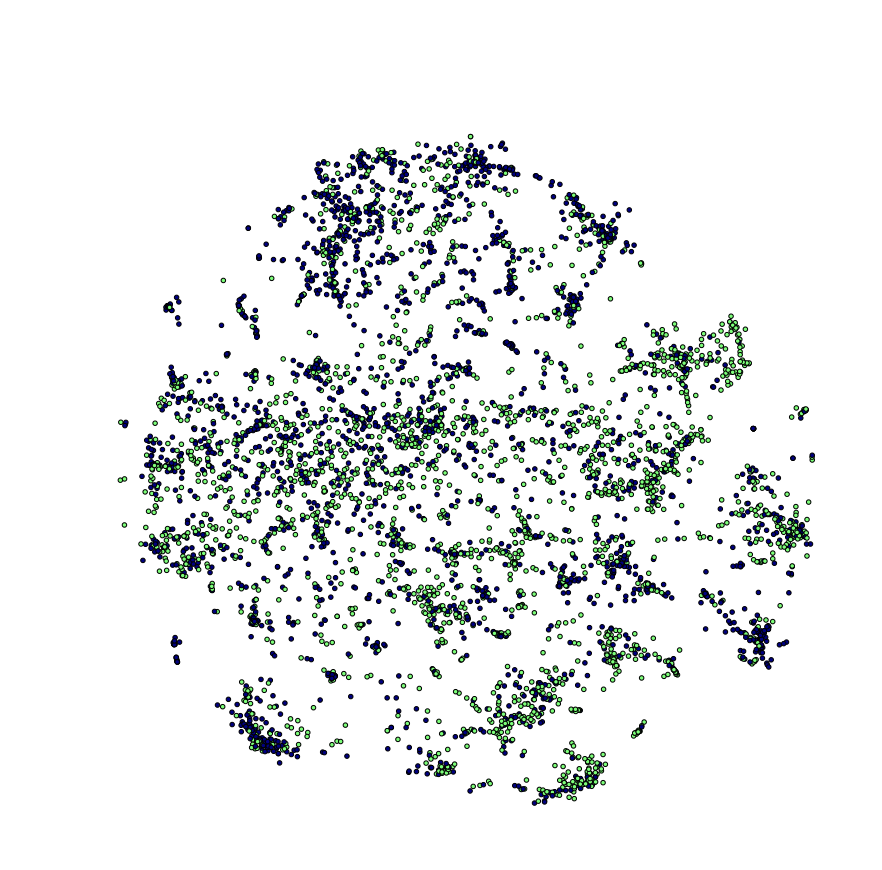

In [586]:
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(XT[:, 0], XT[:, 1], c=map(lambda c: cm(1.0 * c / 2), (Y)))
pl.axis('off')
pl.show()